### Содержание 

[Подготовка данных](#section1)

[Часть 1. Приоритезация гипотез](#section2)

[Часть 2. Анализ A/B-теста](#section3)

[1-5 Построение кумулятивных графиков](#section4)

[6-9 Поиск выбросов](#section5)

[10-13 Проверка гипотез](#section6)

[14 Принятие решения](#section7)

[Общие выводы](#section8)

<a id='section1'></a>
### Подготовка данных

Загрузим датафреймы необходимые для работы. 

In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_orders = pd.read_csv('/datasets/orders.csv')
df_hypothesis = pd.read_csv('/datasets/hypothesis.csv')
df_visitors = pd.read_csv('/datasets/visitors.csv')

In [3]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.8+ KB


In [4]:
df_orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [5]:
df_visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.5+ KB


In [6]:
df_visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Приведем типы даты в необходимый формат для работы над ними. 

In [7]:
df_visitors['date'] = pd.to_datetime(df_visitors['date'], format ='%Y-%m-%d' )
df_orders['date'] = pd.to_datetime(df_orders['date'], format ='%Y-%m-%d' )

<a id='section2'></a>
## Часть 1. Приоритезация гипотез

### Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

Проведем расчет показателя ICE  и отсортируем данный показатель по убыванию. 

In [8]:
df_hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [9]:
df_hypothesis['ICE'] = (df_hypothesis['Impact'] * df_hypothesis['Confidence']) / df_hypothesis['Efforts']
print(df_hypothesis[['Hypothesis','ICE']].sort_values(by = 'ICE', ascending = False))

                                          Hypothesis        ICE
8  Запустить акцию, дающую скидку на товар в день...  16.200000
0  Добавить два новых канала привлечения трафика,...  13.333333
7  Добавить форму подписки на все основные страни...  11.200000
6  Показать на главной странице баннеры с актуаль...   8.000000
2  Добавить блоки рекомендаций товаров на сайт ин...   7.000000
1  Запустить собственную службу доставки, что сок...   2.000000
5  Добавить страницу отзывов клиентов о магазине,...   1.333333
3  Изменить структура категорий, что увеличит кон...   1.125000
4  Изменить цвет фона главной страницы, чтобы уве...   1.000000


### Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

Рассчитаем RICE и отсортируем показания по убыванию. 

In [10]:
df_hypothesis['RICE'] = (df_hypothesis['Reach'] * df_hypothesis['Impact'] * df_hypothesis['Confidence']) / df_hypothesis['Efforts']
print(df_hypothesis[['Hypothesis','RICE']].sort_values(by = 'RICE', ascending = False))

                                          Hypothesis   RICE
7  Добавить форму подписки на все основные страни...  112.0
2  Добавить блоки рекомендаций товаров на сайт ин...   56.0
0  Добавить два новых канала привлечения трафика,...   40.0
6  Показать на главной странице баннеры с актуаль...   40.0
8  Запустить акцию, дающую скидку на товар в день...   16.2
3  Изменить структура категорий, что увеличит кон...    9.0
1  Запустить собственную службу доставки, что сок...    4.0
5  Добавить страницу отзывов клиентов о магазине,...    4.0
4  Изменить цвет фона главной страницы, чтобы уве...    3.0


Изменияни приотеризации гипотез произошло поскольку метрика RICE в отличии от ICE учитывает охват. То есть как много пользователей затронет гипотеза и исходя из этого гипотезы 7 2 0 стали занимать лидерующие позиции в метрики RICE. А гипотеза 8 которая лидировадла в метрике ICE упала на 5 позицию в RICE посокольку имеет не такой большой охват в отличии от гипотез 7 2 0 6.

<a id='section3'></a>
### Часть 2 Анализ А/В теста. 

<a id='section4'></a>
### 1. Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.

Для построения графика кумулятивной выручки по группам. Получим датасет с уникальными парами дата и группа. 

In [11]:
datesGroups = df_orders[['date','group']].drop_duplicates()

In [12]:
ordersAggregated = datesGroups.apply(lambda x: df_orders[np.logical_and(df_orders['date'] <= x['date'], df_orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' :
      pd.Series.nunique, 'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [13]:
ordersAggregated.head(5)

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


Найдем количество визитов в каждую дату. Объединим два датафрейма в один. 

In [14]:
visitorsAggregated = datesGroups.apply(lambda x: df_visitors[np.logical_and(df_visitors['date']<= x['date'],
                                                                           df_visitors['group'] == x['group'])].agg({
    'date': 'max', 'group': 'max','visitors' : 'sum'}),axis = 1).sort_values(by = ['date','group'])

In [15]:
visitorsAggregated.head(5)

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [16]:
cummulativeData = ordersAggregated.merge(visitorsAggregated, left_on = ['date','group'], right_on = ['date','group'])
cummulativeData.columns = ['date','group','orders','buyers','revenue','visitors']

In [17]:
cummulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Построим графики накопления выручки в каждой группе 

In [18]:
commulativA = cummulativeData[cummulativeData['group'] == 'A'][['date','revenue','orders']]
commulativB = cummulativeData[cummulativeData['group'] == 'B'][['date','revenue','orders']]

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


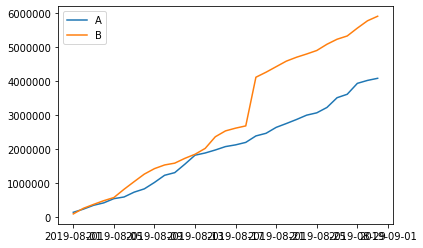

In [19]:
plt.plot(commulativA['date'], commulativA['revenue'], label = 'A')
plt.plot(commulativB['date'], commulativB['revenue'], label = 'B')
plt.legend()
plt.show()

Из построенного графика видно, что от пользователей из группы В получаем большую прибыль. Так же обратим внимание на анамально высокие скачки в группе В по прибыли. 

### 2.Постройте график кумулятивного среднего чека по группам.


Для построения графика среднего чека поделим выручку на заказы. 

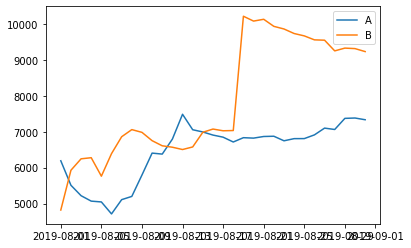

In [20]:
plt.plot(commulativA['date'], commulativA['revenue'] / commulativA['orders'], label = 'A')
plt.plot(commulativB['date'], commulativB['revenue'] / commulativB['orders'], label = 'B')
plt.legend()
plt.show()

По среднему чеку видно как группа В сначала приносила больший среднний чек, а затем просела. Затем наблюдается резкий скачок и это, скорее всего, аномальное значения в группе В.

### 3. Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. 

Для построения графика относительного изменения кумулятивного среднего чека. Объеденим два датафрема - группу А и группу В, и на одном графике найдем соотношение среднего чека одной группы к другой 

In [21]:
commulativRevenue = commulativA.merge(commulativB, left_on = 'date', right_on = 'date', how = 'left' , suffixes =['A','B'] )
commulativRevenue.head(5)

,date,revenueA,ordersA,revenueB,ordersB
0,2019-08-01,148579,24,101217,21
1,2019-08-02,242401,44,266748,45
2,2019-08-03,354874,68,380996,61
3,2019-08-04,425699,84,489567,78
4,2019-08-05,549917,109,581995,101


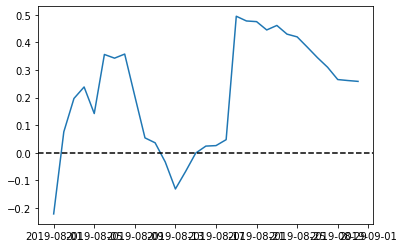

In [22]:
plt.plot(commulativRevenue['date'], (commulativRevenue['revenueB']/commulativRevenue['ordersB']) / (commulativRevenue['revenueA']/
        commulativRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

В начале теста группа В немного проигрывает группе А, но затем вырывается вперед и вновь начинает проигрывать. После этого следует аномальный скачок в группе В. 

###  4.Постройте график кумулятивной конверсии по группам. Сделайте выводы и предположения.

Рассчитаем конверсию каждой группы разделив заказы на визиты и построем график каждой группы. 

In [23]:
cummulativeData['conversion'] =  cummulativeData['orders'] / cummulativeData['visitors'] 
cummulativeDataA = cummulativeData[cummulativeData['group'] == 'A']
cummulativeDataB = cummulativeData[cummulativeData['group']== 'B']

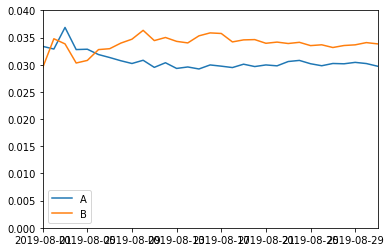

In [24]:
plt.plot(cummulativeDataA['date'], cummulativeDataA['conversion'], label = 'A')
plt.plot(cummulativeDataB['date'],cummulativeDataB['conversion'],label = 'B')
plt.axis(['2019-08-01','2019-08-31',0,0.040])
plt.legend()
plt.show()

После начала теста конверсия группы В растет и затем всегда больше, чем у группы А. Можно сделать вывод, что у группы В, в целом, конверсия выше, чем у группы А. 

### 5. Постройте график относительного изменения кумулятивной конверсии группы B к группе A.

Объединим два датафрема конверсии группы А и В и построим график группы В к А.

In [25]:
commulativeConversion = cummulativeDataA[['date','conversion']].merge(cummulativeDataB[['date','conversion']], left_on = 'date',
                                                                     right_on = 'date', how = 'left' , suffixes = ['A','B'])
commulativeConversion.head()

,date,conversionA,conversionB
0,2019-08-01,0.033380,0.029453
1,2019-08-02,0.032885,0.034776
2,2019-08-03,0.036856,0.033833
3,2019-08-04,0.032787,0.030315
4,2019-08-05,0.032851,0.030793


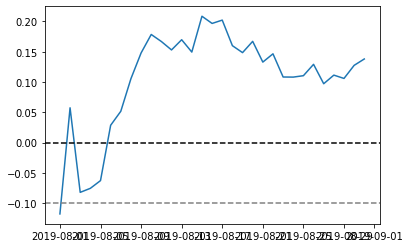

In [26]:
plt.plot(commulativeConversion['date'], commulativeConversion['conversionB'] / commulativeConversion['conversionA'] - 1)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.show()


Видим как в начале теста группа В проигрывает в конверсии затем растет и на протежении всего теста больше, чем у группы А.

<a id='section5'></a>
### 6. Постройте точечный график количества заказов по пользователям.

Найдем количество заказов пользователей в каждый день теста. Постороим точечный график распределения заказов. 

In [27]:
orderByUsers = df_orders.drop(['date','revenue', 'group'],axis =1).groupby('visitorId', as_index = False).agg({
    'transactionId': pd.Series.nunique})
orderByUsers.sort_values(by= 'transactionId', ascending =False).head(10)

,visitorId,transactionId
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


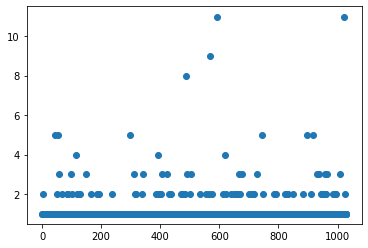

In [28]:
x_values = pd.Series(range(0,len(orderByUsers)))
plt.scatter(x_values, orderByUsers['transactionId'])
plt.show()

Из полученного графика делаем вывод о том, что пользователи чаще совершают 1 заказ, реже 2. Более двух заказов совершаются редко.

###  7. Посчитайте 95-й и 99-й перцентили количества заказов на пользователя.

Найдем перцентили количества заказов.

In [29]:
np.percentile(orderByUsers['transactionId'], [95,99])

array([2., 4.])

Из полученных данных делаем вывод о том, что только 5% пользователей от общего числа совершали 2 заказ. 1% процент пользователй совершал 4 заказа. 

###  8. Постройте точечный график стоимостей заказов.

Построим точечный график стоимости заказов. Подберем маштаб таким образом чтобы видеть с какой суммы начинают заказывать реже.

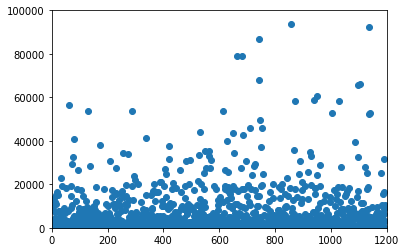

In [30]:
x_values = pd.Series(range(0,len(df_orders)))
plt.scatter(x_values,df_orders['revenue'])
plt.axis([0,1200,0,100000])
plt.show()

Из графика видно, что до 20000 совершается большинстов заказов после этой суммы заказы гораздо реже. 

### 9.Посчитайте 95-й и 99-й перцентили стоимости заказов

Расчитаем перцентили стоимости заказов. 

In [31]:
np.percentile(df_orders['revenue'], [95,99])

array([28000. , 58233.2])

По результам расчета можно сказать - 5% пользователей от общего числа совершали заказ на сумму 28000. 1% пользователей совершал заказ на сумму 58233. 

<a id='section6'></a>
### 10.Посчитайте статистическую значимость различий в конверсии между группами по «сырым» данным

Для расчета стат. значимости различий. Выделим две группы пользователей и количество уникальных заказов в каждой. Затем получим семпл каждой группы, для этого нам необходимо вычести из количества поситетелей количество заказов. Проведем тест Уилкоксона-Манна-Уитни для нахождения статистической значимости конверсии между группами. 

In [32]:
orderByUsersA = df_orders[df_orders['group']=='A'].groupby('visitorId',as_index = False).agg({'transactionId': pd.Series.nunique})
orderByUsersB = df_orders[df_orders['group']=='B'].groupby('visitorId',as_index = False).agg({'transactionId': pd.Series.nunique})


In [33]:
sampleA = pd.concat([orderByUsersA['transactionId'],pd.Series(0,index=np.arange(cummulativeData[cummulativeData['group']=='A']['visitors'].sum() -
len(orderByUsersA['transactionId'])), name='orders')],axis=0)

In [34]:
sampleB = pd.concat([orderByUsersB['transactionId'],pd.Series(0,index=np.arange(cummulativeData[cummulativeData['group']=='B']['visitors'].sum() -
len(orderByUsersB['transactionId'])), name='orders')],axis=0)

In [35]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

0.007


In [36]:
print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

0.144


По результатам теста p-value равно 0.7% порог в 5% не пройден - отвергаем гипотезу о том, что группы А и В равны по конверсии. При этом мы видим, что конверсия группы В выше конверсии группы А на 14%

### 11. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

Проведем тест Уилкоксона-Манна-Уитни со средними чеками каждой группы. 

In [37]:
cummulativeData.head(5)

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033380
1,2019-08-01,B,21,20,101217,713,0.029453
2,2019-08-02,A,44,38,242401,1338,0.032885
3,2019-08-02,B,45,43,266748,1294,0.034776
4,2019-08-03,A,68,62,354874,1845,0.036856


In [38]:
print("{0:.3f}".format(stats.mannwhitneyu(cummulativeData[cummulativeData['group']=='A']['revenue'],
                    cummulativeData[cummulativeData['group']=='B']['revenue'])[1]))

0.053


In [39]:
print("{0:.3f}".format(stats.mannwhitneyu(cummulativeData[cummulativeData['group']=='A']['revenue'],
                    cummulativeData[cummulativeData['group']=='B']['revenue'])[1]))

print("{0:.3f}".format(cummulativeData[cummulativeData['group']=='B']
['revenue'].mean()/cummulativeData[cummulativeData['group']=='A']['revenue'].mean()-1))

0.053
0.435


Результат теста p-value 5.3%, причин отвергать нулевую гипотезу нет т.к. различий между группами по среднему чеку нет. Но при этом средний чек группы В на 43.5% больше, чем у группы А. Мы можем сделать предположение об ошибке первого рода в результатах теста, поскольку тест говорит об отсутвиии различий групп, а соотношение средних чеков говорит о том, что чек группы В выше почти на 44%. Отчистим данные от выбросов и проведем тесты повторно. 

### 12. Посчитайте статистическую значимость различий в конверсии между группами по «очищенным» данным

Из вычисления перцентилей стоимости заказов и количества заказов мы можем определить среднего пользователя. 

Заказ на сумму не более 20000 

Количество заказов не более 3. 

In [40]:
orderByUsersA.head()

,visitorId,transactionId
0,8300375,1
1,11685486,1
2,54447517,1
3,66685450,1
4,78758296,1


Найдем аномальных пользователей и их количество. 

In [41]:
usersWithManyOrders = pd.concat([orderByUsersA[orderByUsersA['transactionId'] >
3]['visitorId'], orderByUsersB[orderByUsersB['transactionId'] > 3]['visitorId']], axis
= 0)
usersWithExpensiveOrders = df_orders[df_orders['revenue'] > 20000]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders],
axis = 0).drop_duplicates().sort_values()
print(abnormalUsers.head(5))
print(abnormalUsers.shape)

568     113298937
1099    148427295
461     154576532
18      199603092
928     204675465
Name: visitorId, dtype: int64
(90,)


90 аномальных пользователей. Очистим данные и проведем тест Уилкоксона-Манна-Уитни на очишеных данных.

In [42]:
sampleAFiltered = pd.concat([orderByUsersA[np.logical_not(orderByUsersA['visitorId'].isin(abnormalUsers))]['transactionId'],pd.Series(0,
index=np.arange(cummulativeData[cummulativeData['group']=='A']['visitors'].sum() -
len(orderByUsersA['transactionId'])),name='orders')],axis=0)

sampleBFiltered = pd.concat([orderByUsersB[np.logical_not(orderByUsersB['visitorId'].isin(abnormalUsers))]['transactionId'],pd.Series(0,
index=np.arange(cummulativeData[cummulativeData['group']=='B']['visitors'].sum() -
len(orderByUsersB['transactionId'])),name='orders')],axis=0)

In [43]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.010
0.158


В результате теста p-value 1% это меньше порога в 5% можно сделать вывод, что у групп А и В действительно разная конверсия. У группы B конверсия выше на 15.8%. 

###  13. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

Проведем тест Уилкоксона-Манна-Уитни по статистичкой значимости средних чеков по группам. 

In [44]:
print("{0:.3f}".format(stats.mannwhitneyu(df_orders[np.logical_and(df_orders['group']=='A',np.logical_not(df_orders['visitorId'].isin(
    abnormalUsers)))]['revenue'],df_orders[np.logical_and(df_orders['group']=='B',np.logical_not(
    df_orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))


print("{0:.3f}".format(df_orders[np.logical_and(df_orders['group']=='B',np.logical_not(df_orders['visitorId'].isin(
    abnormalUsers)))]['revenue'].mean()/df_orders[np.logical_and(df_orders['group']=='A',np.logical_not(
    df_orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1))

0.464
-0.005


По получемым результатам p-value 46.4% порог в 5% пройден, гипотезу о равенстве средних чеков двух группу принимаем. Разница между между средними чеками двух групп отсутвует. 

<a id='section7'></a>
### 14.Примите решение по результатам теста и объясните его. Варианты решений: 

1. Остановить тест, зафиксировать победу одной из групп.

2. Остановить тест, зафиксировать отсутствие различий между группами. 

3. Продолжить тест.

По результатм теста получены следующие показатели: 

Сырые данные :

1. Конвсерсии двух групп по результатам теста p-value равно 0.7%. Конверсия группы В выше конверсии группы А на 14%

2. Средний чек двух групп Результат теста p-value 5.3%. Средний чек группы В на 43.5% больше, чем у группы А

Очищеные данные :

1. Конверсии двух групп по результату теста p-value равно 1%. У группы B конверсия выше на 15.8%.

2. Средний чек двух групп по результату теста p-value равно 46.4%. Разница между между средними чеками двух групп отсутвует.

Из полученных результатов делаем вывод, что конверсия группы В в целом выше конверсии группы А на 15%.  При этом после очистки данных от аномальных значений, мы получили, что различий в среднем чеке нет. Ключевым фактором в данном тесте является наличие выбросов у группы В. После устранения выбросов можно сделать вывод номер 2 об остановке теста и фиксирование отсутствия различий между группами. 

<a id='section8'></a>
### Общие выводы :

В результате работы было установлено различие методов ICE и RICE в способе приоритезации гипотез. Метод ICE не учитывает охват аудитории гипотезы и из-за этого приоритезация гипотез изменяется. 

Построены кумалятивные графики различных метрик(выручка, средниий  чек, конверсия). Было установлено как выбросы влияют на результаты А/В теста. А именно искажают значение p-value и из-за этого есть вероятность допустить ошибку в итоговых результатах, и как итог, выбрать неверную гипотезу. 